# Part 1a)

In [34]:
# calculate QR, RQ iteration until convergence
# store resulting eigenvectors

X = rand(5,5)
A = X + X'
evals_A = eigvals(A)
evecs_A = eigvecs(A)
X = eye(similar(A)) # matrix to populate with eigenvectors
for n = 0:100
    Q,R = qr(A)
    A = R*Q
    X = X * Q
end
#print computed eigenvalues and eigenvectors
A,X,evecs_A,evals_A

(
5x5 Array{Float64,2}:
  5.02012        5.61292e-16   1.64588e-16  -4.18273e-16  -2.86162e-16
  1.70264e-46    1.73836      -4.94965e-17   6.3366e-16   -6.42194e-16
 -4.07605e-71   -5.03728e-27   0.997134     -4.91271e-6   -2.23097e-16
  9.7512e-77     5.35591e-32  -4.91271e-6   -0.856208     -3.74168e-17
  9.70472e-156  -8.3273e-110   5.83844e-85   2.95035e-79  -0.143997   ,

5x5 Array{Float64,2}:
 -0.425591   0.727935  -0.331291   0.364062  -0.216071
 -0.512112  -0.419398  -0.419756   0.205706   0.585949
 -0.432232  -0.116907  -0.274534  -0.754694  -0.393163
 -0.468473  -0.390834   0.491741   0.398339  -0.476757
 -0.387713   0.357486   0.629978  -0.311299   0.477601,

5x5 Array{Float64,2}:
  0.364062  -0.216071  -0.331292   0.727935  -0.425591
  0.205705   0.585949  -0.419756  -0.419398  -0.512112
 -0.754694  -0.393163  -0.274532  -0.116907  -0.432232
  0.398341  -0.476757   0.49174   -0.390834  -0.468473
 -0.311297   0.477601   0.629979   0.357486  -0.387713,

[-0.856208,-0.143997,

## compare difference in iterated eigenvalues vs. built-in function

In [46]:
#sort(diag(A),rev=true)-sort(evals_A,rev=true)
i_eigIt = sortperm(diag(A),rev=true) #order of calculated eigenvalues
i_eigBI = sortperm(evals_A,rev=true) #order of eigenvalues from built in function
computed = diag(A)

computed[i_eigIt] - evals_A[i_eigBI]

5-element Array{Float64,1}:
 -1.77636e-15
 -8.88178e-16
 -1.30216e-11
 -8.04912e-16
  1.30221e-11

In [48]:
## compare difference in iterated eigenvectors vs. built-in function

In [49]:
X[:,i_eigIt]-evecs_A[:,i_eigBI]

5x5 Array{Float64,2}:
 -2.22045e-16   3.33067e-16   9.65031e-7   3.33067e-16   8.78166e-7
 -2.22045e-16  -4.44089e-16   5.45271e-7   1.11022e-16   1.11266e-6
 -2.22045e-16   9.57567e-16  -2.00049e-6   1.05471e-15   7.27712e-7
 -5.55112e-16  -1.66533e-16   1.05589e-6  -8.32667e-16  -1.30347e-6
  5.55112e-16   3.33067e-16  -8.25168e-7   5.55112e-17  -1.6699e-6 

In [1]:
eigvals(X + X'), sort(eigvals(A))

LoadError: X not defined
while loading In[1], in expression starting on line 1

In [ ]:
## result: there is correspondence between the values that result from 100 iterations of QR, 

# problem 2 - Matrix addition #

In [5]:
# iterates over rows (outer loop)
# iterates over columns (inner loop)
function matadd1!(C, A, B)
    m,n = size(A)
    (m,n) == size(B) || error("matrix sizes must match")
    for i = 1:m
        for j = 1:n
            @inbounds C[i,j] = A[i,j] + B[i,j]
        end
    end
    return C
end
matadd1(A,B) = matadd1!(similar(A, promote_type(eltype(A),eltype(B))), A,B)

# same as matadd1 except the loop order is reversed
# iterates over columns (outer loop)
# iterates over rows (inner loop)
function matadd2!(C, A, B)
    m,n = size(A)
    (m,n) == size(B) || error("matrix sizes must match")
    for j = 1:n
        for i = 1:m
            @inbounds C[i,j] = A[i,j] + B[i,j]
        end
    end
    return C
end
matadd2(A,B) = matadd2!(similar(A, promote_type(eltype(A),eltype(B))), A,B)

matadd2 (generic function with 1 method)

In [6]:
# correctness check:
A = rand(5,7)
B = rand(5,7)
norm(matadd1(A,B) - (A+B)), norm(matadd2(A,B) - (A+B))

(0.0,0.0)

## run benchmark ##

In [7]:
N = round(Int, linspace(10, 1000, 200))
t0 = Float64[]
t1 = Float64[]
t2 = Float64[]
for n in N
    A = rand(n,n)
    B = rand(n,n)
    C = similar(A)
    push!(t0, @elapsed A+B) # note: does not preallocate output
    push!(t1, @elapsed matadd1!(C,A,B))
    push!(t2, @elapsed matadd2!(C,A,B))
end

INFO: Loading help data...


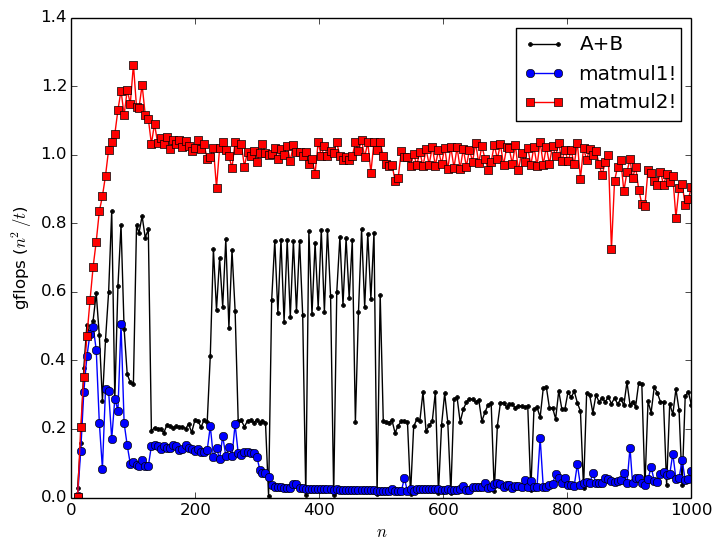

PyObject <matplotlib.legend.Legend object at 0x7f91bb32ca90>

In [8]:
using PyPlot

plot(N, N.^2 ./ t0 * 1e-9, "k.-")
plot(N, N.^2 ./ t1 * 1e-9, "bo-")
plot(N, N.^2 ./ t2 * 1e-9, "rs-")
xlabel(L"n")
ylabel(L"gflops ($n^2/t$)")
legend(["A+B","matmul1!","matmul2!"])

## matadd without pre allocation ## 

In [15]:
function matadd1_allocate(A, B)
    m,n = size(A)
    (m,n) == size(B) || error("matrix sizes must match")
    C = similar(A, promote_type(eltype(A),eltype(B))) # preallocate C
    for i = 1:m
        for j = 1:n
            @inbounds C[i,j] = A[i,j] + B[i,j]
        end
    end
    return C
end

# same as matadd1 except the loop order is reversed
function matadd2_allocate(A, B)
    m,n = size(A)
    (m,n) == size(B) || error("matrix sizes must match")
    C = similar(A, promote_type(eltype(A),eltype(B))) # preallocate    
    for j = 1:n
        for i = 1:m
            @inbounds C[i,j] = A[i,j] + B[i,j]
        end
    end
    return C
end

matadd2_allocate (generic function with 1 method)

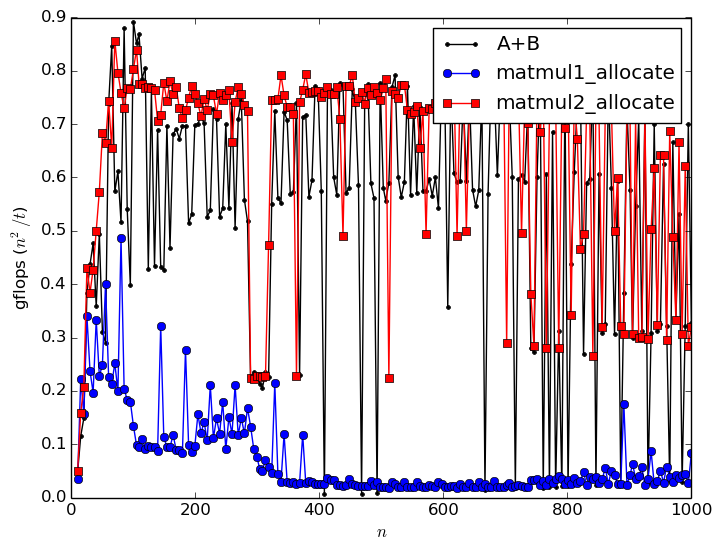

PyObject <matplotlib.legend.Legend object at 0x7f778018a2d0>

In [20]:
### Benchmark for preallocated 
N = round(Int, linspace(10, 1000, 200))
t0 = Float64[]
t1 = Float64[]
t2 = Float64[]
for n in N
    A = rand(n,n)
    B = rand(n,n)
    push!(t0, @elapsed A+B) # note: does not preallocate output
    push!(t1, @elapsed matadd1_allocate(A,B))
    push!(t2, @elapsed matadd2_allocate(A,B))
end

plot(N, N.^2 ./ t0 * 1e-9, "k.-")
plot(N, N.^2 ./ t1 * 1e-9, "bo-")
plot(N, N.^2 ./ t2 * 1e-9, "rs-")
xlabel(L"n")
ylabel(L"gflops ($n^2/t$)")
legend(["A+B","matmul1_allocate","matmul2_allocate"])

## 'A+B' is closer to column-major ordering
code for the Julia operation 'A+B' uses the following code:

            for i=1:length(A)
                @inbounds F[i] = ($f)(A[i], B[i])
            end
            
Where $f is addition ':+'. The indices 1:length(A) travel first down the first by row and then start at the begining of the next column. This is column-major order which is represented in the loop ordering of matadd2. The flop counts rates of A+B are closer matmul2, so this is consistent with the prediction. 


## Part 2c
Suppose you wanted to compute C=A+3B+4A.^2 (noting that .^ is element-wise squaring, not matrix
squaring A^2) in Julia. Based on your results above, how/why might you make this faster (if you needed
to)? (Matters would be harder to improve in Matlab or Python, where loops written in the language
are slow.)

In [9]:
function complex_add1(A, B)
    m,n = size(A)
    (m,n) == size(B) || error("matrix sizes must match")
    C = similar(A, promote_type(eltype(A),eltype(B))) # preallocate C
    for i = 1:m
        for j = 1:n
            @inbounds C[i,j] = A[i,j] + 3*B[i,j] + 4*(A[i,j])^2 #A+3B+4A.^2
        end
    end
    return C
end

function complex_add2(A, B)
    m,n = size(A)
    (m,n) == size(B) || error("matrix sizes must match")
    C = similar(A, promote_type(eltype(A),eltype(B))) # preallocate C
    for j = 1:n
        for i = 1:m
            @inbounds C[i,j] = A[i,j] + 3*B[i,j] + 4*(A[i,j])^2 #A+3B+4A.^2
        end
    end
    return C
end

complex_add2 (generic function with 1 method)

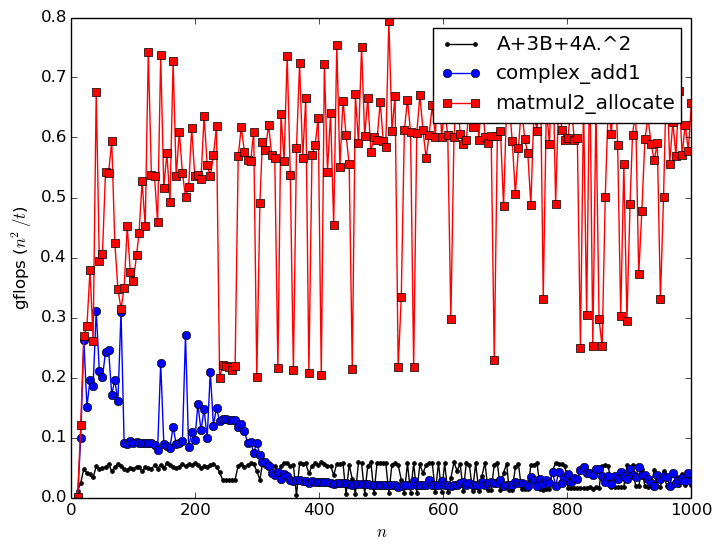

PyObject <matplotlib.legend.Legend object at 0x7f91ac3aef90>

In [10]:
### Benchmark for preallocated 
N = round(Int, linspace(10, 1000, 200))
t0 = Float64[]
t1 = Float64[]
t2 = Float64[]
for n in N
    A = rand(n,n)
    B = rand(n,n)
    push!(t0, @elapsed (A+3B+4A.^2)) # note: does not preallocate output
    push!(t1, @elapsed complex_add1(A,B))
    push!(t2, @elapsed complex_add2(A,B))
end

plot(N, N.^2 ./ t0 * 1e-9, "k.-")
plot(N, N.^2 ./ t1 * 1e-9, "bo-")
plot(N, N.^2 ./ t2 * 1e-9, "rs-")
xlabel(L"n")
ylabel(L"gflops ($n^2/t$)")
legend(["A+3B+4A.^2","complex_add1","complex_add2"])

## Results of A+3B+4A.^2 calculation:

-The naive implimentation is slowest (for small matrices). This is because it has to loop through each entry on two seperate occations.

-In 'complex_add1' each entry of A and B are manipulated only once. Because it does these operations in row-major oder, however it can be slower than the naive implimentation for larger matrices

-'complex_add2' is the fastest because it handles each entry only once in column-major order.

# Part 3b
Schur factorization --> eigenvectors

In [20]:
A = rand((5,5,))
T,Q = schur(A)

A-Q*T*Q'# check factorization
evals = eigvals(A)
evecs = eigvecs(A)
#T, evals

(A - evals[1]*eye(5)) \ zeros(5)


5-element Array{Complex{Float64},1}:
 0.0+0.0im
 0.0+0.0im
 0.0+0.0im
 0.0+0.0im
 0.0+0.0im

In [32]:
#gaussian_elim
function gaussian_elim(A)
    m,n = size(A)
    C = similar(A, promote_type(eltype(A))) # preallocate    
    U = copy(A)
    L = eye(m)
    for k= 1:(m-1)
        for j=(k+1):m
            L[j,k] = U[j,k]/U[k,k]
            U[j,k:m] = U[j,k:m] - L[j,k]*U[k,k:m]
        end
    end
    return L,U
end

gaussian_elim (generic function with 1 method)

In [41]:
    m,n = size(A)
    C = similar(A, promote_type(eltype(A))) # preallocate    
    U = copy(A)
    L = eye(m)
mtrx = [A zeros(5)]
L,U = gaussian_elim(mtrx)

eigx = zeros(n)
for i = 1:m
   k = m-1
    eigx[k] = U[k,k]
end

k = 4
eigx[k] = 

(
5x5 Array{Float64,2}:
  1.0        0.0       0.0       0.0      0.0
  4.50106    1.0       0.0       0.0      0.0
  5.61796    1.17286   1.0       0.0      0.0
 10.2869     2.18378   1.56072   1.0      0.0
  0.791937  -0.078153  0.726537  1.34354  1.0,

5x6 Array{Float64,2}:
 0.0970991     0.839538   0.69044    0.65666       0.187229  0.0
 5.55112e-17  -3.76202   -2.39685   -2.5745       -0.697927  0.0
 0.0           0.0       -0.737319  -0.541696      0.151356  0.0
 0.0           0.0        0.0        0.348123      0.119005  0.0
 0.0           0.0        0.0        5.55112e-17   0.266376  0.0)

In [69]:
function back_subs(R,b)
    x = zeros(similar(b))
    sumVal = 0
    for j= 1:m
        for k=(j+1):m
            sumVal = sumVal + x[k]*R[j,k]
        end
        x[j] = (b[j] - sumVal)/R[j,j]
        sumVal = 0
    end
    return x
end

back_subs (generic function with 1 method)

In [75]:
R = U
b = zeros(5)
    x = zeros(similar(b))
    sumVal = 0
    for j= 1:m
        for k=(j+1):m
            sumVal = sumVal + x[k]*R[j,k]
        end
        x[j] = (b[j] - sumVal)/R[j,j]
        sumVal = 0
    end
    

In [80]:
A = [2 -3 1; 1 -2 1; 1 -3 2]
eigvals(A)
eigvecs(A)

3x3 Array{Complex{Float64},2}:
 0.57735+0.0im  0.849467+0.0im       0.849467-0.0im     
 0.57735+0.0im  0.341881-0.11423im   0.341881+0.11423im 
 0.57735+0.0im  0.176176-0.342691im  0.176176+0.342691im

In [82]:
A = [1 -1; 1 1]
eigvals(A)

2-element Array{Complex{Float64},1}:
 1.0+1.0im
 1.0-1.0im